### IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

### Load Seaborn's Built-in Dataset on the Titanic

In [2]:
Titanic = sns.load_dataset('titanic')

In [3]:
DF = pd.DataFrame(Titanic)
display(DF)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


Survived is the target, it is a binary feature, 1 = survived and 0= died.
Pclass indicates the whether 1st, 2nd or 3rd class.
Sibsp represents the number of siblings or spouses aboard the Titanic.
Parch is the number of parents or children aboard the Titanic.
Fare is the Passenger fare.
Embarked means Port of boarding (Cherbourg, Queenstown, Southampton).


In [4]:
#Looking at the shape of the data
DF.shape

(891, 15)

In [5]:
# There are 891 rows and 15 columns.

#### First thing to check here, is to view the missing values.

In [6]:
import missingno as msno
#missingno package will help us view which columns have missing values.

<AxesSubplot:>

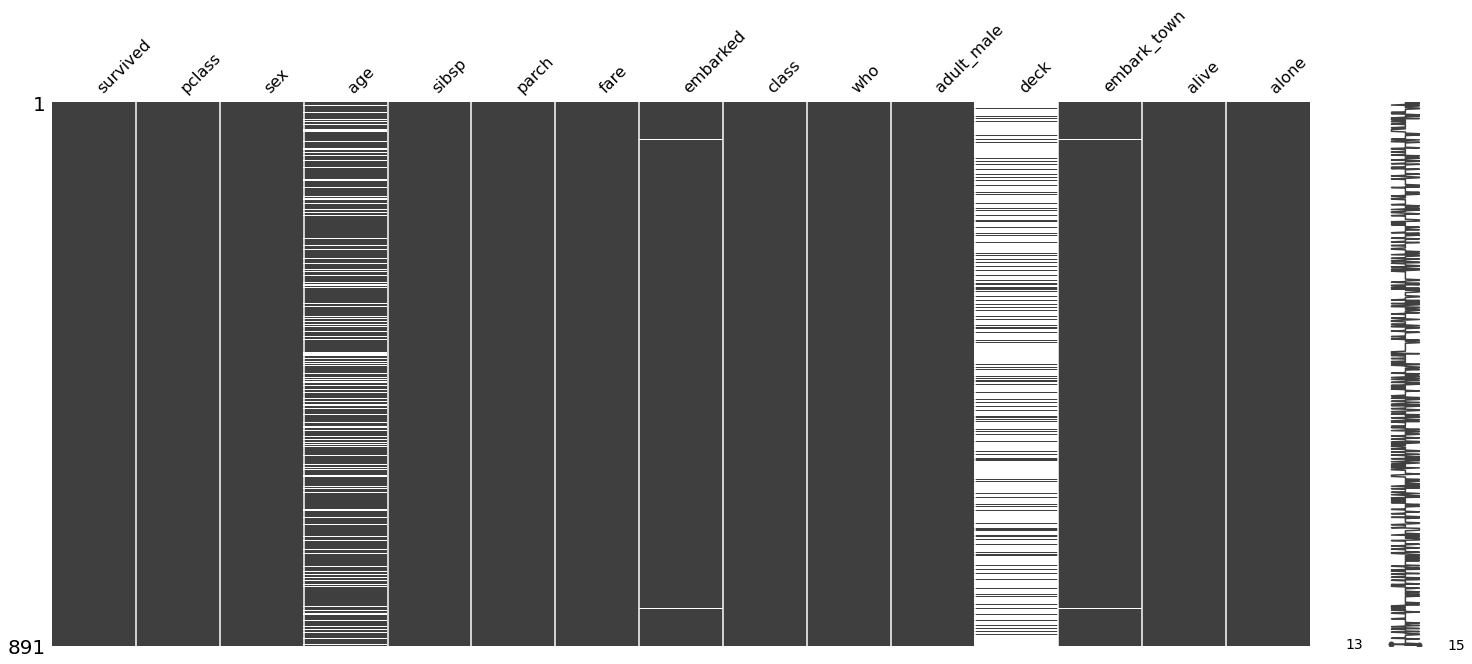

In [7]:
msno.matrix(DF)
#This will show the missing values within each column.

In [8]:
DF.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [9]:
# age, deck, embarked, and embarked_town all have missing values. There are 177 rows with NA values in the age 
# column. Only 2 rows have NA values for embarked column. This is really significant, there are 688 NA values in 
# the deck column and remember there were 891 rows total, so 77% of the deck column has NA values. 

### Visualizing the Age Range:

<AxesSubplot:>

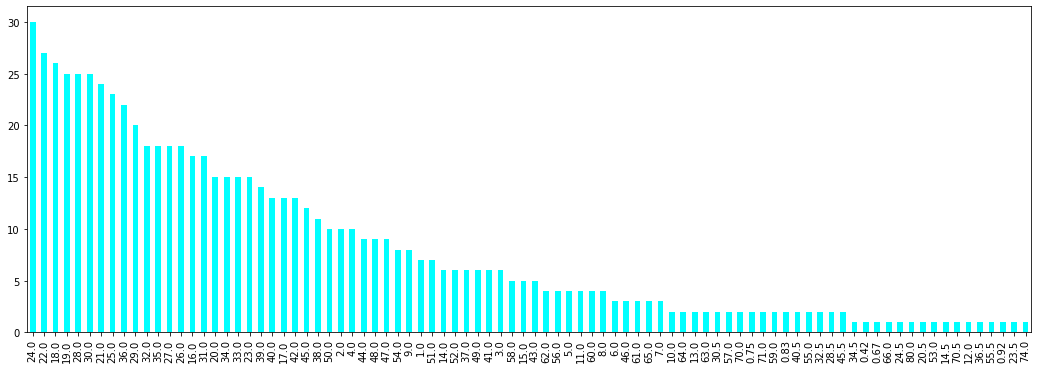

In [10]:
DF.age.value_counts().plot(kind='bar', figsize=(18, 6), color='cyan')

In [11]:
### This bar plot above visualizes the age column so you can see how many passengers were 24, 22, 18, etc. Looks
### like there were more people in their 20s and 30s as well as several 18/19 year olds on the ship.

### Viewing the data below after the preliminary analysis to decide which features to keep for the random forest. Target is survival and will be predicting which features contributed to higher chances of survival.

In [12]:
DF.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
Titanic2 =DF.drop(['class', 'embarked', 'who', 'adult_male', 'parch', 'deck', 'alive'], axis=1)

In [14]:
# The above variables are being dropped to prevent multicolinearity due to related variables. For example, who, 
# adult_male, and sex all contain the same information so only one of those columns should be kept. The embarked
# and embark_town column are the same so only 1 needs to be kept. Alive contains the same information as survived
# so that column is dropped, etc. 

In [15]:
Titanic2.head()

,survived,pclass,sex,age,sibsp,fare,embark_town,alone
0,0,3,male,22.0,1,7.2500,Southampton,False
1,1,1,female,38.0,1,71.2833,Cherbourg,False
2,1,3,female,26.0,0,7.9250,Southampton,True
3,1,1,female,35.0,1,53.1000,Southampton,False
4,0,3,male,35.0,0,8.0500,Southampton,True


### Recoding the String Variables to Numeric to Prepare for Decision Tree / Random Forest

In [16]:
# Will use the value_counts() to view how many levels are within each column.

In [17]:
Titanic2.sex.value_counts()

male      577
female    314
Name: sex, dtype: int64

In [18]:
# recode set up for the sex column:

In [19]:
def recode (sex):
    if sex=="male":
        return 0
    if sex=="female":
        return 1
Titanic2['sexR'] = Titanic2['sex'].apply(recode)

In [20]:
Titanic2.embark_town.value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [21]:
def recode (embark):
    if embark=="Southampton":
        return 0
    if embark=="Cherbourg":
        return 1
    if embark=="Queenstown":
        return 2
Titanic2['embark_townR'] = Titanic2['embark_town'].apply(recode)

In [22]:
# The alone column was a boolean so changing to integer instead of doing a recode.

In [23]:
Titanic2["alone"] = Titanic2["alone"].values.astype("int")

In [24]:
Titanic2.alone.value_counts()

1    537
0    354
Name: alone, dtype: int64

In [25]:
# Checking to make sure our recodes are reflected in the data:

In [26]:
Titanic2.head()

,survived,pclass,sex,age,sibsp,fare,embark_town,alone,sexR,embark_townR
0,0,3,male,22.0,1,7.2500,Southampton,0,0,0.0
1,1,1,female,38.0,1,71.2833,Cherbourg,0,1,1.0
2,1,3,female,26.0,0,7.9250,Southampton,1,1,0.0
3,1,1,female,35.0,1,53.1000,Southampton,0,1,0.0
4,0,3,male,35.0,0,8.0500,Southampton,1,0,0.0


In [27]:
Titanic2.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      891 non-null    int64  
 1   pclass        891 non-null    int64  
 2   sex           891 non-null    object 
 3   age           714 non-null    float64
 4   sibsp         891 non-null    int64  
 5   fare          891 non-null    float64
 6   embark_town   889 non-null    object 
 7   alone         891 non-null    int64  
 8   sexR          891 non-null    int64  
 9   embark_townR  889 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 69.7+ KB


In [28]:
print(Titanic2.dtypes)

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
fare            float64
embark_town      object
alone             int64
sexR              int64
embark_townR    float64
dtype: object


In [29]:
Titanic2.describe()

,survived,pclass,age,sibsp,fare,alone,sexR,embark_townR
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,29.699118,0.523008,32.204208,0.602694,0.352413,0.362205
std,0.486592,0.836071,14.526497,1.102743,49.693429,0.489615,0.477990,0.636157
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,14.454200,1.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,31.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,512.329200,1.000000,1.000000,2.000000


### After our recoding we will view the data again using the missingno package

<AxesSubplot:>

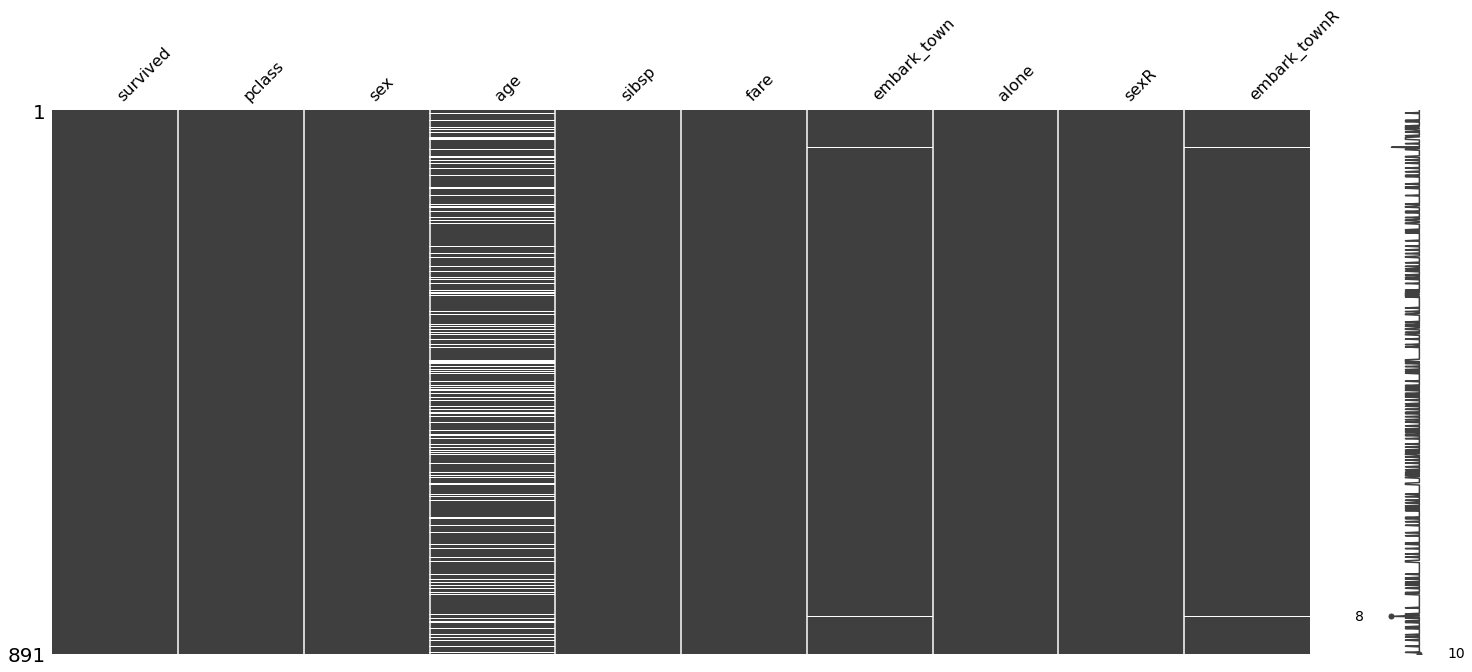

In [30]:
msno.matrix(Titanic2)
#This will show the missing values within each column.

### We are going to drop the NA values from the data.

In [31]:
Titanic3 = Titanic2
# I like doing this in case I make a mistake so I don't have to start over. This way, I can just revert back 
# to Titanic2 if I need to :)

In [32]:
Titanic3.dropna(inplace=True)

<AxesSubplot:>

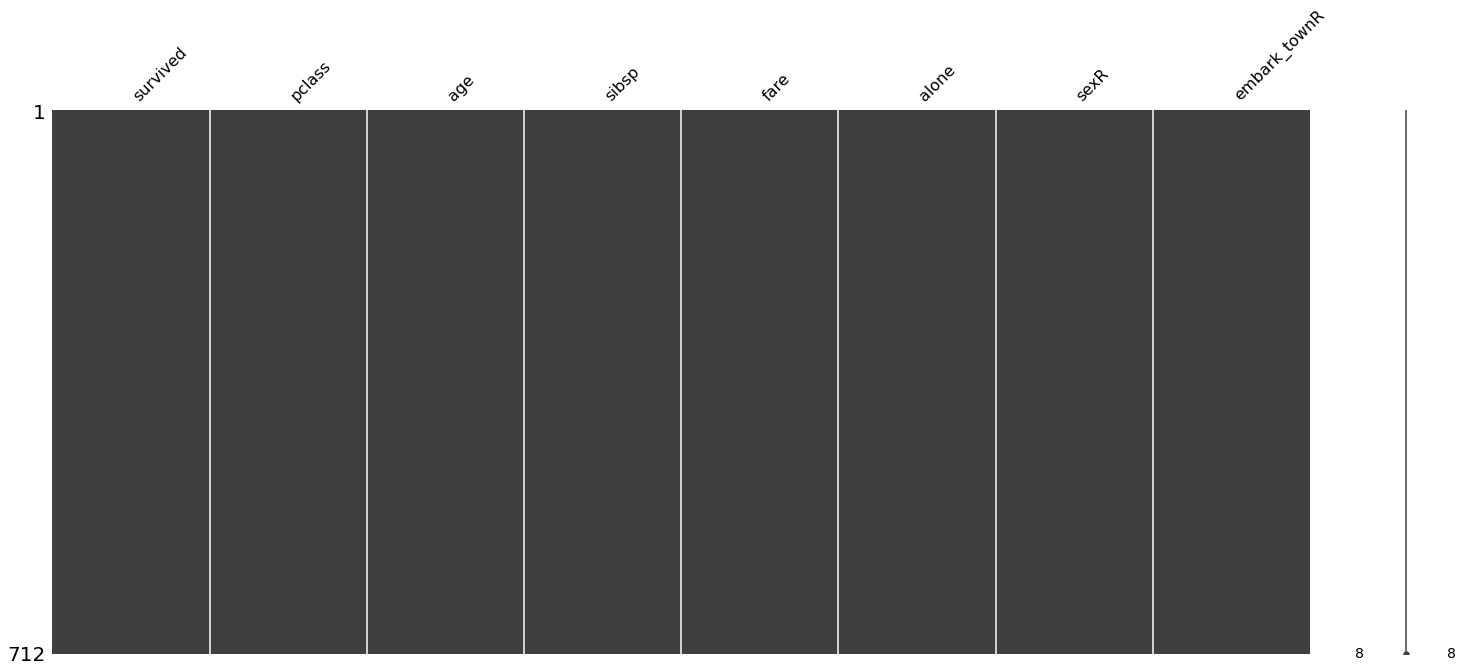

In [88]:
msno.matrix(Titanic3)

In [34]:
# Now we see all the missing data is removed. Below is another way to check for NA values:

In [35]:
Titanic3.isnull().values.any()

False

In [36]:
# We see the confirmation that all the NA's are removed so we will continue.

In [37]:
from skimpy import skim

### Summary statistics using skim() function from the skimpy package.

In [38]:
skim(Titanic3)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 712    │ │ int64       │ 5     │                                                          │
│ │ Number of columns │ 10     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0      ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ survived            │    0 │       0 │     0.4 │    0.49 │       0 │      0 │      1 │       1 │  █    ▅   │  │
│ │ pclass              │    0 │       0 │     2.2 │    0.84 │       1 │      1 │      3 │       3 │  ▄  ▄ █   │  │
│ │ age                 │    0 │       0 │      30 │      14 │    0.42 │     20 │     38 │      80 │   ▂██▃▁   │  │
│ │ sibsp               │    0 │       0 │    0.51 │    0.93 │       0 │      0 │      1 │       5 │    █▃     │  │
│ │ fare                │    0 │       0 │      35 │      53 │       0 │    8.1 │     33 │     510 │    █▁     │  │
│ │ alone               │    0 │       0 │    0.56 │     0.5 │       0 │      0 │      1 │       1 │  ▆    █   │  │
│ │ sexR                │    0 │       0 │    0.36 │    0.48 │       0 │      0 │      1 │       1 │  █    ▅   │  │
│ │ embark_townR        │    0 │       0 │    0.26 │    0.52 │       0 │      0 │      0 │       2 │   █  ▂    │  │
│ └─────────────────────┴──────┴─────────┴─────────┴─────────┴─────────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ sex                       │       0 │          0 │                            1 │                      710 │  │
│ │ embark_town               │       0 │          0 │                            1 │                      710 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [39]:
# The above table shows us so much information about the data, what types of datatypes we have, the columns, 
# how many NA values and %s. Notice that there is 0 because we dropped the NA values. Also, we can see we no 
# longer have 891 rows because we dropped NA's. 

In [40]:
#pip install -U pandas-profiling
#recently learned about pandas profiling from my colleague Matthew. I absolutely love it, shows so much about the data.

In [41]:
from pandas_profiling import ProfileReport

In [42]:
profile = ProfileReport(Titanic3, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

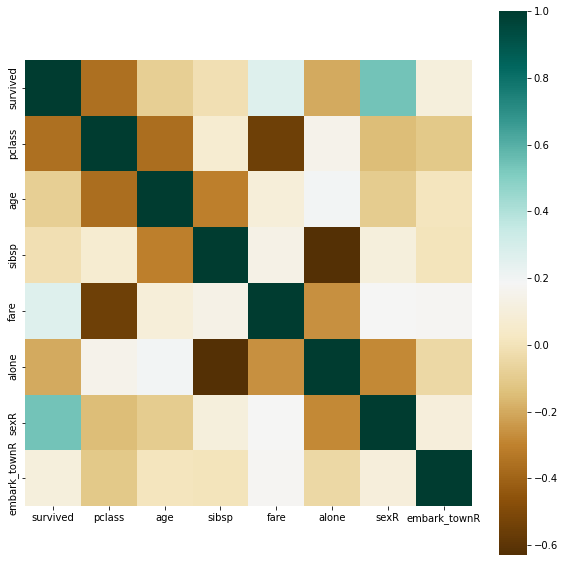

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(Titanic3.corr(), square=True, cmap='BrBG')

### Getting Data Prepared for Decision Tree / Random Forest

In [44]:
Titanic3.drop(['sex', 'embark_town'], axis=1, inplace= True)

In [45]:
Titanic3.head()

,survived,pclass,age,sibsp,fare,alone,sexR,embark_townR
0,0,3,22.0,1,7.2500,0,0,0.0
1,1,1,38.0,1,71.2833,0,1,1.0
2,1,3,26.0,0,7.9250,1,1,0.0
3,1,1,35.0,1,53.1000,0,1,0.0
4,0,3,35.0,0,8.0500,1,0,0.0


<AxesSubplot:xlabel='age', ylabel='alone'>

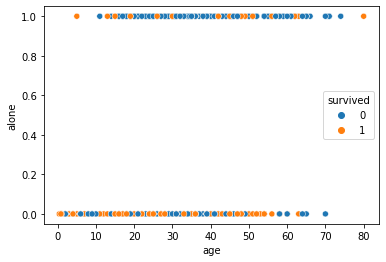

In [46]:
sns.scatterplot(data=Titanic3, x='age', y='alone', hue='survived')

In [47]:
# The scatterplot above may not be the best visualization, but we can see from a glance the sad fact that more 
# people who were alone, did not survive compared to people who were not alone.

<Figure size 432x288 with 0 Axes>

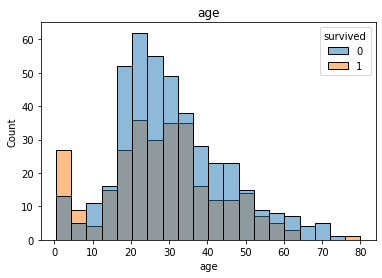

<Figure size 432x288 with 0 Axes>

In [48]:
sns.histplot(x=Titanic3['age'], hue=Titanic3['survived']).set(title='age')
plt.figure()

In [49]:
# Changing the survived column from int to bool:

In [50]:
Titanic3.survived = Titanic3.survived.astype('int')
Titanic3.dtypes

survived          int64
pclass            int64
age             float64
sibsp             int64
fare            float64
alone             int64
sexR              int64
embark_townR    float64
dtype: object

In [51]:
col = Titanic3.loc[:, ['pclass', 'age', 'sibsp', 'fare', 'alone', 'sexR', 'embark_townR']]
col

,pclass,age,sibsp,fare,alone,sexR,embark_townR
0,3,22.0,1,7.2500,0,0,0.0
1,1,38.0,1,71.2833,0,1,1.0
2,3,26.0,0,7.9250,1,1,0.0
3,1,35.0,1,53.1000,0,1,0.0
4,3,35.0,0,8.0500,1,0,0.0
...,...,...,...,...,...,...,...
885,3,39.0,0,29.1250,0,1,2.0
886,2,27.0,0,13.0000,1,0,0.0
887,1,19.0,0,30.0000,1,1,0.0
889,1,26.0,0,30.0000,1,0,1.0


### Histograms of Variables using Seaborn Package

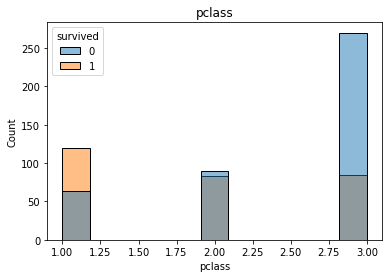

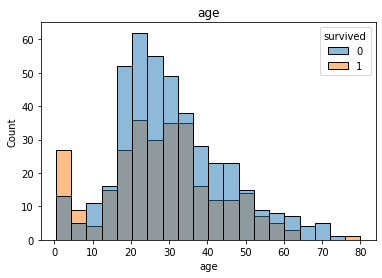

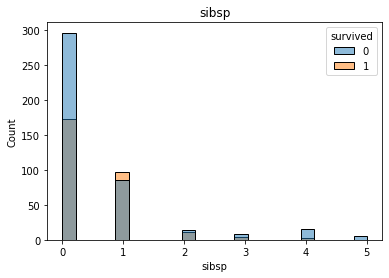

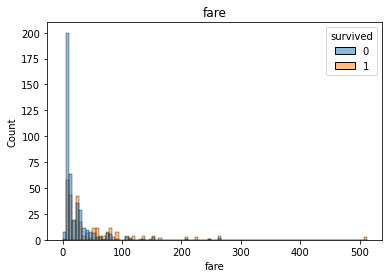

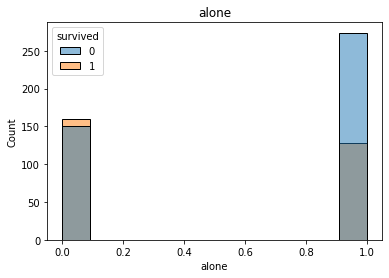

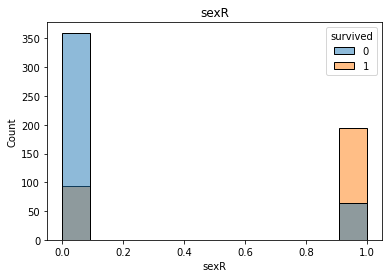

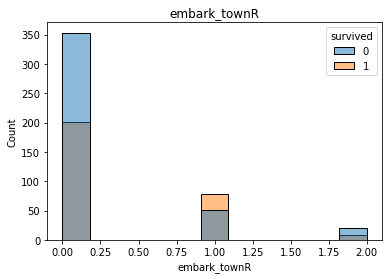

<Figure size 432x288 with 0 Axes>

In [52]:
for cl in col:
    sns.histplot(x=Titanic3[cl], hue=Titanic3['survived']).set(title=cl)
    plt.figure()

In [53]:
# The plots above offer great insight into the features in relations to survival. 

### Specifying Variables for Analysis

In [54]:
features = col
target = Titanic3['survived']
#In a few cells above I selected my feature variables and stored them in variable "col."
#I am also declaring my target variable survived since we are creating a model to predict survival.

In [55]:
col.head()

,pclass,age,sibsp,fare,alone,sexR,embark_townR
0,3,22.0,1,7.2500,0,0,0.0
1,1,38.0,1,71.2833,0,1,1.0
2,3,26.0,0,7.9250,1,1,0.0
3,1,35.0,1,53.1000,0,1,0.0
4,3,35.0,0,8.0500,1,0,0.0


In [56]:
col.dtypes

pclass            int64
age             float64
sibsp             int64
fare            float64
alone             int64
sexR              int64
embark_townR    float64
dtype: object

In [57]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [58]:
Titanic3.survived.value_counts()

0    424
1    288
Name: survived, dtype: int64

In [59]:
# Our target variable now needs to change to int to run the tree plot.

In [60]:
target = target.astype('int')
target.dtypes

dtype('int64')

In [61]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

### Train test split 80/20

In [62]:
x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=0.2, random_state=61)

### Creating a Decision Tree

In [63]:
decisionTree = DecisionTreeClassifier(random_state=61)
decisionTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=61)

In [64]:
treePredictions = decisionTree.predict(x_test)
print(confusion_matrix(y_test, treePredictions))

[[60 18]
 [21 44]]


The top row shows that 60 were correctly predicted not to survive, and did not survive. Top right, 18 were predicted to not 
survive but actually lived. Bottom left shows 21 were predicted to live, but did not survive, and the bottom right
shows 44 were correctly predicted to live and did live.

In [65]:
print(classification_report(y_test, treePredictions))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75        78
           1       0.71      0.68      0.69        65

    accuracy                           0.73       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.73      0.73      0.73       143



In [66]:
# Above we see that the overall accuracy of this model is 73%.

### Visualizing the Confusion Matrix 

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix

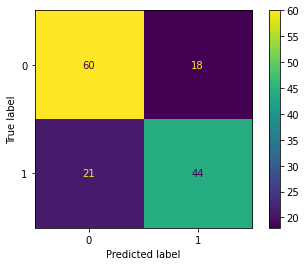

In [68]:
predicted_labels = decisionTree.predict(x_test)
cm=confusion_matrix(y_test, predicted_labels, labels=decisionTree.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decisionTree.classes_)
disp.plot()
plt.show()


In [69]:
#changing colors to blue tones:

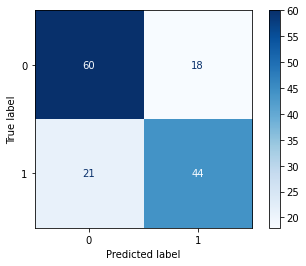

In [70]:
predicted_labels = decisionTree.predict(x_test)
cm=confusion_matrix(y_test, predicted_labels, labels=decisionTree.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decisionTree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [71]:
from sklearn.metrics import ( accuracy_score, recall_score, precision_score, f1_score)


In [72]:
def PrintPredictions(y_test, y_pred): #function to pull the predicted y values
   
    results = [accuracy_score, recall_score, precision_score, f1_score]
    markers = ['Accuracy', 'Recall', 'Precision', 'F1']
    for result, markers in zip(results, markers):
        if markers == 'Accuracy':
            print(f"{markers}: {result(y_test, y_pred): .3f}")
        else:
            print(f"{markers}: {result(y_test, y_pred, average='weighted'):.3f}")
#referenced from Dr. Lumian

In [89]:
# the .3f in the above code is rounding up to three decimal places.
# the f" is an f string and will pull from defined values using curly brackets {}.
# here is a really great site to learn about f strings:
# https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/

In [74]:
PrintPredictions(y_test, predicted_labels)

Accuracy:  0.727
Recall: 0.727
Precision: 0.727
F1: 0.727


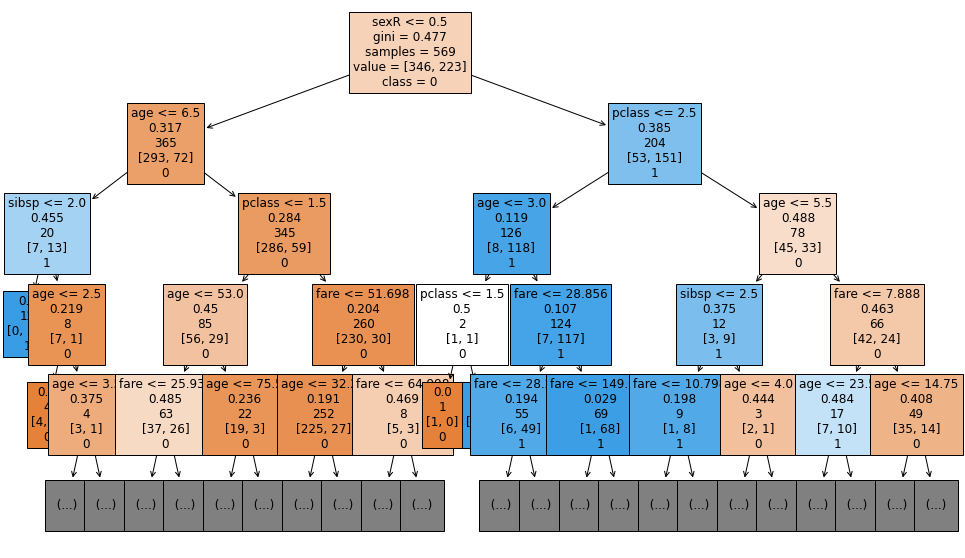

In [75]:
fig = plt.figure(figsize=(17,10))
TREEPLOT = tree.plot_tree(decisionTree,
                   feature_names=col.columns,
                   class_names=target.unique().astype(str), max_depth=4,
                   filled=True, label='root', fontsize=12)

### Random Forest

In [76]:

X_train, X_test, y_train, y_test = train_test_split(
    col, 
    target,
    test_size=0.2,
    random_state=61,
    stratify=target
)

In [77]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(569, 7)
(143, 7)
(569,)
(143,)


In [78]:
from sklearn.ensemble import RandomForestClassifier

RANFOR = RandomForestClassifier(n_estimators=10, random_state=1)
RANFOR.fit(X_train, y_train)
RANFOR_PREDICTIONS = RANFOR.predict(X_test)

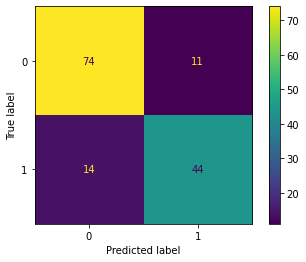

In [79]:
from sklearn.svm import SVC
SVC(random_state=1)
cm2=confusion_matrix(y_test,RANFOR_PREDICTIONS, labels=RANFOR.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=RANFOR.classes_)
disp.plot()
plt.show()

In [80]:
# above code I used, I learned by referencing :https://scikit-learn.org/0.24/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#examples-using-sklearn-metrics-confusionmatrixdisplay

In [81]:
def plot_tree(est_num=0):
    plt.figure(figsize=(17,10))
    feature_names=col.columns
    class_names=target.unique().astype(str)
    tree.plot_tree(RANFOR.estimators_[est_num],
                   feature_names = col.columns, 
                   class_names = target.unique().astype(str),
                   filled = True, fontsize=12, max_depth=3)


In [82]:
RANFOR.estimators_

[DecisionTreeClassifier(max_features='auto', random_state=1791095845),
 DecisionTreeClassifier(max_features='auto', random_state=2135392491),
 DecisionTreeClassifier(max_features='auto', random_state=946286476),
 DecisionTreeClassifier(max_features='auto', random_state=1857819720),
 DecisionTreeClassifier(max_features='auto', random_state=491263),
 DecisionTreeClassifier(max_features='auto', random_state=550290313),
 DecisionTreeClassifier(max_features='auto', random_state=1298508491),
 DecisionTreeClassifier(max_features='auto', random_state=2143362693),
 DecisionTreeClassifier(max_features='auto', random_state=630311759),
 DecisionTreeClassifier(max_features='auto', random_state=1013994432)]

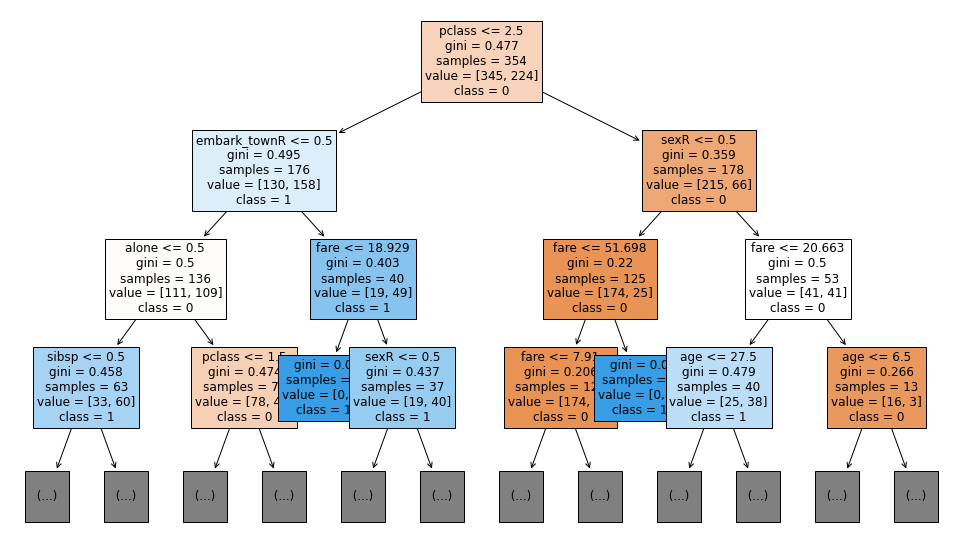

In [83]:
plot_tree(est_num=1)


### Looking at Feature Importance

In [84]:
feature_importances = pd.Series(RANFOR.feature_importances_, index=col.columns)
feature_importances.sort_values(inplace=True, ascending=True)
print(feature_importances)

alone           0.023483
embark_townR    0.035964
sibsp           0.050700
pclass          0.099095
sexR            0.240189
fare            0.252991
age             0.297578
dtype: float64


### Ploting Feature Importance

<AxesSubplot:>

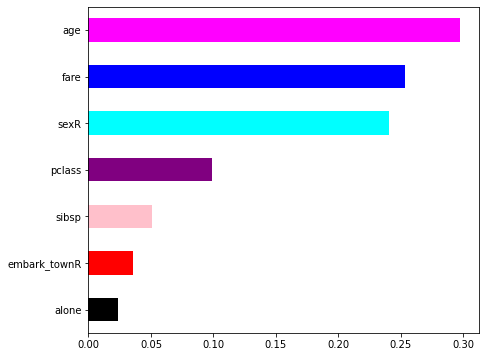

In [85]:
feature_importances.plot(kind='barh', figsize=(7,6), color=['black', 'red', 'pink', 'purple', 'cyan', 'blue', 'magenta'])

In [86]:
# Age and fare are the greatest predictors of survival.

In [87]:
# Hope you enjoyed this notebook! <3 Mia